In [1]:
# !pip install pandas numpy nltk gensim scikit-learn pyLDAvis spacy

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brend\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Brend\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os
import re
import json
import numpy as np
import pandas as pd

In [4]:
import pandas as pd

# Replace the file name with dataset path if different
df = pd.read_csv("../datasets/final_dataset.csv")

# Check the first few rows
df.head()

,critic_name,rotten_tomatoes_link,movie_title,content_rating,genres,original_release_date,review_content,review_type,movie_info
0,andrew l. urban,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,a fantasy adventure that fuses greek mythology...,fresh,"always trouble-prone, the life of teenager per..."
1,louise keller,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,"uma thurman as medusa, the gorgon with a coiff...",fresh,"always trouble-prone, the life of teenager per..."
2,ben mceachen,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,whether audiences will get behind the lightnin...,fresh,"always trouble-prone, the life of teenager per..."
3,ethan alter,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,what's really lacking in the lightning thief i...,rotten,"always trouble-prone, the life of teenager per..."
4,david germain,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,it's more a list of ingredients than a movie-m...,rotten,"always trouble-prone, the life of teenager per..."


In [5]:
# Aggregate by link, keep title as part of the document and keep link as the ID
df["rotten_tomatoes_link"] = df["rotten_tomatoes_link"].str.strip()
df["combined_review"] =  df["review_content"].fillna("")

reviews_agg = df.groupby("rotten_tomatoes_link").agg({

    "movie_title": lambda x: x.dropna().astype(str).mode().iat[0],
    "original_release_date": lambda x: x.dropna().astype(str).mode().iat[0],
    "movie_info": lambda x: x.dropna().astype(str).mode().iat[0],
    "genres": lambda x: ", ".join(sorted({
        g.strip()
        for g in ",".join(x.dropna().astype(str)).split(",")
        if g.strip()
    })),
    "combined_review": lambda x: " ".join(x.dropna().astype(str))   # moved to last
    
}).reset_index().rename(columns={
    "rotten_tomatoes_link": "movie_link",
    "original_release_date": "year"
})

# ----------------------------------------------
# Reorder columns so combined_review is last
# ----------------------------------------------
cols = [c for c in reviews_agg.columns if c != "combined_review"] + ["combined_review"]
reviews_agg = reviews_agg[cols]

# ----------------------------------------------
# Display sample rows
# ----------------------------------------------
reviews_agg.head()

,movie_link,movie_title,year,movie_info,genres,combined_review
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"always trouble-prone, the life of teenager per...","action & adventure, comedy, drama, science fic...",a fantasy adventure that fuses greek mythology...
1,m/0878835,please give,2010,kate (catherine keener) and her husband alex (...,comedy,"like holofcener's previous pictures, please gi..."
2,m/10,10,1979,"a successful, middle-aged hollywood songwriter...","comedy, romance",10 (1979) is known for its numerical rating sy...
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,following the closing arguments in a murder tr...,"classics, drama","a film with texture, humour and relevance at a..."
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"in 1866, professor pierre m. aronnax (paul luk...","action & adventure, drama, kids & family",[the] embodiment of disney at his best -- fami...


In [6]:
# Check how many times each movie_link appears
link_counts = reviews_agg['movie_link'].value_counts()
# Check how many times each movie_title appears
title_counts = reviews_agg['movie_title'].value_counts()

# Find links that appear more than once
duplicate_links = link_counts[link_counts > 1]
duplicate_titles= title_counts[title_counts > 1]

print(f"Number of movie_links appearing more than once: {len(duplicate_links)}")
print(f"Number of movie_titles appearing more than once: {len(duplicate_titles)}")

Number of movie_links appearing more than once: 0
Number of movie_titles appearing more than once: 500


In [7]:
# Find all movie titles that appear more than once
duplicate_titles = reviews_agg["movie_title"].value_counts()
duplicate_titles = duplicate_titles[duplicate_titles > 1]

duplicate_titles

movie_title
hamlet                  5
alice in wonderland     4
home                    4
the three musketeers    4
little women            4
                       ..
wild bill               2
wolves                  2
3:10 to yuma            2
dark water              2
criminal                2
Name: count, Length: 500, dtype: int64

In [8]:
# Show full duplicate entries with their reviews
duplicate_entries = reviews_agg[reviews_agg["movie_title"].isin(duplicate_titles.index)]

duplicate_entries

,movie_link,movie_title,year,movie_info,genres,combined_review
7,m/1000123-310_to_yuma,3:10 to yuma,1957,"dan evans (van heflin), a drought-plagued ariz...","classics, drama, western","despite an abundance of talk, this 1957 film i..."
10,m/10002114-dark_water,dark water,2002,"in this moody japanese horror film, newly-sing...","art house & international, horror, mystery & s...",...while dark water isn't a complete wash (no ...
17,m/10003276-criminal,criminal,2004,needing a new partner capable of intricate con...,"drama, mystery & suspense",we got two and a half more months of crap to g...
22,m/10003925-dead_end,dead end,2003,when a family en route to a christmas eve gath...,"comedy, horror, mystery & suspense",like a twilight zone episode stretched out int...
28,m/10004288-running_scared,running scared,2006,mafia flunky joey gazelle (paul walker) is ord...,"action & adventure, drama, mystery & suspense",an unapologetic in-your-face thriller that's s...
...,...,...,...,...,...,...
16029,m/wild_bill,wild bill,1995,gunfighter wild bill hickok (jeff bridges) tra...,"action & adventure, drama, western",the movie itself is a lot of deadwood in the c...
16030,m/wild_bill_2011,wild bill,2011,"after serving a prison sentence, bill connects...","art house & international, drama",the steady - but never sluggish - pace allows ...
16136,m/wolves,wolves,2014,a high-school student (lucas till) goes in sea...,action & adventure,"wolves is part bumbling ya wannabe, part goofy..."
16137,m/wolves_2016,wolves,2017,anthony is a standout player on his manhattan ...,drama,"save the highly predictable decider, the on-co..."


In [9]:
# Create a combined text column for embeddings
reviews_agg['text_for_embedding'] = (
    reviews_agg['movie_title'].fillna('') + ' ' +
    reviews_agg['movie_info'].fillna('')+' '+
    reviews_agg['combined_review'].fillna('')
).str.strip()

# Keep relevant columns for embeddings including movie_title
embedding_df = reviews_agg[['movie_link', 'movie_title', 'year','genres', 'text_for_embedding']].copy()

# Check a few rows
print("Sample of combined text for embedding:")
display(embedding_df.head(5))

Sample of combined text for embedding:


,movie_link,movie_title,year,genres,text_for_embedding
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"action & adventure, comedy, drama, science fic...",percy jackson & the olympians: the lightning t...
1,m/0878835,please give,2010,comedy,please give kate (catherine keener) and her hu...
2,m/10,10,1979,"comedy, romance","10 a successful, middle-aged hollywood songwri..."
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,"classics, drama",12 angry men (twelve angry men) following the ...
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"action & adventure, drama, kids & family","20,000 leagues under the sea in 1866, professo..."


In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
import re

# -----------------------------------------
# 1. Setup stopwords
# -----------------------------------------
stop_words = set(stopwords.words('english'))
extra_stopwords = {"movie", "film", "films", "story", "character"}
stop_words.update(extra_stopwords)

# -----------------------------------------
# 2. Lemmatizer
# -----------------------------------------
lemmatizer = WordNetLemmatizer()

# -----------------------------------------
# 3. Cleaning 
# -----------------------------------------
def clean_text(text):
    # Keep letters only
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    text = text.lower()
    return text

# -----------------------------------------
# 4. Tokenization + Lemmatization
# -----------------------------------------
def preprocess(text):
    tokens = simple_preprocess(text, deacc=True)

    # Remove stopwords + short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

# -----------------------------------------
# 5. Apply to dataset
# -----------------------------------------
embedding_df["cleaned_text"] = embedding_df["text_for_embedding"].apply(clean_text)
embedding_df["tokens"] = embedding_df["cleaned_text"].apply(preprocess)

embedding_df[["movie_link", "movie_title","year", "genres", "tokens"]].head()

,movie_link,movie_title,year,genres,tokens
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"action & adventure, comedy, drama, science fic...","[percy, jackson, olympian, lightning, thief, a..."
1,m/0878835,please give,2010,comedy,"[please, give, kate, catherine, keener, husban..."
2,m/10,10,1979,"comedy, romance","[successful, middle, aged, hollywood, songwrit..."
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,"classics, drama","[angry, men, twelve, angry, men, following, cl..."
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"action & adventure, drama, kids & family","[league, sea, professor, pierre, aronnax, paul..."


In [11]:
from gensim.corpora import Dictionary

# Create dictionary from tokens
dictionary = Dictionary(embedding_df["tokens"])

# Filter very rare and very frequent words
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in embedding_df["tokens"]]

print("Dictionary size:", len(dictionary))
print("Example BOW for first movie:", corpus[0][:10])

Dictionary size: 25540
Example BOW for first movie: [(0, 1), (1, 1), (2, 1), (3, 2), (4, 9), (5, 3), (6, 1), (7, 1), (8, 7), (9, 1)]


In [12]:
#Topic weight distribution
from gensim.models.ldamodel import LdaModel

num_topics = 30

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    chunksize=2000,
    update_every=1,
    alpha='auto',
    eta='auto'
)

lda_model.print_topics(num_topics=10)

[(np.int64(24),
  '0.053*"brother" + 0.017*"clooney" + 0.016*"charlie" + 0.015*"reitman" + 0.015*"george" + 0.015*"coen" + 0.011*"kevin" + 0.010*"jason" + 0.010*"payne" + 0.010*"cohen"'),
 (np.int64(7),
  '0.045*"lee" + 0.024*"harry" + 0.021*"magic" + 0.017*"solondz" + 0.017*"todd" + 0.016*"hill" + 0.016*"potter" + 0.014*"food" + 0.013*"wright" + 0.013*"world"'),
 (np.int64(22),
  '0.033*"lawrence" + 0.023*"jennifer" + 0.018*"russell" + 0.017*"keaton" + 0.016*"cooper" + 0.015*"jordan" + 0.014*"cat" + 0.014*"alice" + 0.013*"chastain" + 0.013*"hunger"'),
 (np.int64(17),
  '0.037*"rock" + 0.025*"wild" + 0.023*"johnson" + 0.020*"witherspoon" + 0.013*"beatles" + 0.011*"batman" + 0.010*"knight" + 0.009*"reese" + 0.008*"band" + 0.008*"superman"'),
 (np.int64(26),
  '0.069*"bond" + 0.058*"james" + 0.051*"robert" + 0.030*"martin" + 0.026*"scorsese" + 0.023*"perry" + 0.020*"daniel" + 0.016*"craig" + 0.012*"niro" + 0.011*"tyler"'),
 (np.int64(23),
  '0.016*"family" + 0.007*"dog" + 0.005*"wilson" 

In [13]:
# Check genre column
embedding_df["genres"] = embedding_df["genres"].fillna("").astype(str)

embedding_df["genre_list"] = embedding_df["genres"].apply(
    lambda x: [g.strip() for g in x.split(",")] if x.strip() else []
)

print("Sample genres (raw):")
display(embedding_df["genres"].iloc[:5])
print("Sample genre_list (raw):")
display(embedding_df["genre_list"].iloc[:5])

Sample genres (raw):


0    action & adventure, comedy, drama, science fic...
1                                               comedy
2                                      comedy, romance
3                                      classics, drama
4             action & adventure, drama, kids & family
Name: genres, dtype: object

Sample genre_list (raw):


0    [action & adventure, comedy, drama, science fi...
1                                             [comedy]
2                                    [comedy, romance]
3                                    [classics, drama]
4           [action & adventure, drama, kids & family]
Name: genre_list, dtype: object

In [14]:
# list unique raw tokens and counts for inspection
from collections import Counter
flat = [g.strip() for lst in embedding_df['genre_list'] for g in lst if isinstance(g, str) and g.strip()]
genre_counts = Counter(flat)
import pandas as pd
genre_df = pd.DataFrame.from_records(list(genre_counts.items()), columns=['genre_raw','count']).sort_values('count', ascending=False).reset_index(drop=True)
print("Unique raw genres:", len(genre_df))
display(genre_df.head(80))

Unique raw genres: 21


,genre_raw,count
0,drama,9012
1,comedy,5296
2,action & adventure,3333
3,mystery & suspense,3315
4,art house & international,2335
5,horror,1838
6,romance,1833
7,documentary,1827
8,science fiction & fantasy,1754
9,classics,1594


In [15]:
# -----------------------------------------
# Genre Normalization Map
# -----------------------------------------
genre_map = {
    "art house & international": "international",
    "special interest": "documentary",
    "faith & spirituality": "drama",
    "gay & lesbian": "romance",
    "anime & manga": "animation and manga",
    "animation": "animation and manga",
}

# Genres to completely drop
drop_genres = {"cult movies"}

# -----------------------------------------
# Apply the mapping
# -----------------------------------------
def normalize_genre_list(genre_list):
    cleaned = []

    for g in genre_list:
        g = g.strip().lower()

        # Drop unwanted genres
        if g in drop_genres:
            continue

        # Replace using the mapping
        if g in genre_map:
            cleaned.append(genre_map[g])
        else:
            cleaned.append(g)

    return cleaned

# Apply to dataframe
embedding_df["genre_list"] = embedding_df["genre_list"].apply(normalize_genre_list)

# check new distribution
from collections import Counter
flat = [g for lst in embedding_df["genre_list"] for g in lst]
Counter(flat)

Counter({'drama': 9084,
         'comedy': 5296,
         'action & adventure': 3333,
         'mystery & suspense': 3315,
         'documentary': 2993,
         'international': 2335,
         'romance': 1905,
         'horror': 1838,
         'science fiction & fantasy': 1754,
         'classics': 1594,
         'kids & family': 1039,
         'musical & performing arts': 935,
         'animation and manga': 567,
         'western': 291,
         'television': 211,
         'sports & fitness': 169})

In [16]:
# -----------------------------------------
# 1. Compute per-document topic distributions
# -----------------------------------------
import numpy as np
import pandas as pd

# Function to get dense topic vector from LDA for a single document
def get_topic_vector(bow, num_topics=num_topics):
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    # Convert to dense vector
    vec = np.zeros(num_topics)
    for topic_id, prob in topic_dist:
        vec[topic_id] = prob
    return vec

# Apply to all documents in embedding_df
topic_vectors = [get_topic_vector(bow) for bow in corpus]  # corpus is your BoW corpus

# Convert to DataFrame and assign topic columns
topic_cols = [f"Topic_{i}" for i in range(num_topics)]
topic_df = pd.DataFrame(topic_vectors, columns=topic_cols)

# Merge topic columns into embedding_df
embedding_df = pd.concat([embedding_df.reset_index(drop=True), topic_df], axis=1)

# inspect
embedding_df.head()


,movie_link,movie_title,year,genres,text_for_embedding,cleaned_text,tokens,genre_list,Topic_0,Topic_1,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"action & adventure, comedy, drama, science fic...",percy jackson & the olympians: the lightning t...,percy jackson the olympians the lightning t...,"[percy, jackson, olympian, lightning, thief, a...","[action & adventure, comedy, drama, science fi...",0.000075,0.004040,...,0.004682,0.000243,0.000027,0.034519,0.000025,0.000049,0.002594,0.120299,0.139629,0.023316
1,m/0878835,please give,2010,comedy,please give kate (catherine keener) and her hu...,please give kate catherine keener and her hu...,"[please, give, kate, catherine, keener, husban...",[comedy],0.037076,0.000039,...,0.000083,0.000077,0.000028,0.000094,0.000026,0.000051,0.000032,0.001672,0.066979,0.000050
2,m/10,10,1979,"comedy, romance","10 a successful, middle-aged hollywood songwri...",a successful middle aged hollywood songwri...,"[successful, middle, aged, hollywood, songwrit...","[comedy, romance]",0.000793,0.034793,...,0.000845,0.000792,0.000283,0.000967,0.000269,0.000519,0.057039,0.000335,0.187681,0.000514
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,"classics, drama",12 angry men (twelve angry men) following the ...,angry men twelve angry men following the ...,"[angry, men, twelve, angry, men, following, cl...","[classics, drama]",0.000272,0.045379,...,0.163324,0.030639,0.048634,0.000332,0.000092,0.000178,0.004097,0.000115,0.000609,0.000176
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"action & adventure, drama, kids & family","20,000 leagues under the sea in 1866, professo...",leagues under the sea in professo...,"[league, sea, professor, pierre, aronnax, paul...","[action & adventure, drama, kids & family]",0.000560,0.000285,...,0.016425,0.000560,0.000200,0.000682,0.000190,0.018196,0.015663,0.279265,0.001342,0.000363


In [17]:
# -----------------------------------------
# 2. Expand genres into rows (one genre per row per movie)
# -----------------------------------------
movies_exploded = (
    embedding_df
    .assign(genre_list=embedding_df["genre_list"])  # make sure we use cleaned genre_list
    .explode("genre_list")
)

# Remove empty/None genres just in case
movies_exploded = movies_exploded[movies_exploded["genre_list"].notna()]
movies_exploded["genre_list"] = movies_exploded["genre_list"].str.strip()

# -----------------------------------------
# 3. Identify topic columns
# -----------------------------------------
topic_cols = [col for col in movies_exploded.columns if col.startswith("Topic_")]

# -----------------------------------------
# 4. Compute average topic weight per genre
# -----------------------------------------
genre_topic_weights = (
    movies_exploded
    .groupby("genre_list")[topic_cols]
    .mean()
)

# inspect results
genre_topic_weights.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
genre_list,,,,,,,,,,,,,,,,,,,,,
action & adventure,0.034411,0.008064,0.024172,0.060028,0.010416,0.030677,0.048161,0.006314,0.056305,0.010089,...,0.061727,0.032801,0.005472,0.030586,0.004770,0.027490,0.008022,0.042717,0.114762,0.018035
animation and manga,0.019971,0.014057,0.032491,0.050055,0.006207,0.034051,0.042644,0.009023,0.016915,0.003009,...,0.011471,0.055325,0.004152,0.037258,0.003023,0.014509,0.001525,0.314642,0.116478,0.025357
classics,0.026355,0.027991,0.051524,0.044797,0.042859,0.037142,0.082309,0.008231,0.060655,0.022011,...,0.047576,0.042664,0.008990,0.039073,0.007129,0.028824,0.016628,0.014237,0.043017,0.040233
comedy,0.029950,0.018451,0.121182,0.018029,0.012950,0.115564,0.077020,0.005827,0.012225,0.009141,...,0.022187,0.024046,0.006339,0.057360,0.008419,0.019355,0.007534,0.032324,0.179987,0.017222
documentary,0.023400,0.031983,0.032744,0.049961,0.006161,0.023250,0.092185,0.005273,0.010834,0.005962,...,0.019434,0.045980,0.003329,0.026181,0.004090,0.011963,0.004212,0.014998,0.036111,0.010930


In [18]:
import pandas as pd
import numpy as np

# -----------------------------------------
# Prepare topic matrices
# -----------------------------------------
# movie_topic_matrix: rows = movies, columns = topics
movie_topic_matrix = embedding_df[[col for col in embedding_df.columns if col.startswith("Topic_")]].values

# genre_topic_matrix: rows = genres, columns = topics
genre_topic_matrix = genre_topic_weights.values
genre_list = genre_topic_weights.index.tolist()

# -----------------------------------------
# Compute weighted genre scores per movie
# -----------------------------------------
weighted_scores = movie_topic_matrix @ genre_topic_matrix.T  # matrix multiplication
weighted_scores_df = pd.DataFrame(weighted_scores, columns=genre_list, index=embedding_df.index)

# -----------------------------------------
# Select top 5 genres per movie
# -----------------------------------------
top_n = 5
def top_n_genres(row, n=top_n):
    top_scores = row.nlargest(n)
    # Normalize to 100%
    top_scores_normalized = (100 * top_scores / top_scores.sum()).round(0).astype(int)
    return pd.Series(top_scores_normalized)

top_genres_df = weighted_scores_df.apply(top_n_genres, axis=1)

# -----------------------------------------
# Combine with movie info
# -----------------------------------------
movie_genres_df = pd.concat([embedding_df[["movie_link","movie_title","year"]], top_genres_df], axis=1)
movie_genres_df.head()

,movie_link,movie_title,year,action & adventure,animation and manga,classics,comedy,documentary,drama,horror,international,kids & family,musical & performing arts,mystery & suspense,romance,science fiction & fantasy,sports & fitness,television,western
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,18.0,26.0,NaN,14.0,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,19.0,NaN,NaN,NaN
1,m/0878835,please give,2010,NaN,NaN,NaN,19.0,NaN,21.0,NaN,23.0,NaN,NaN,NaN,24.0,NaN,13.0,NaN,NaN
2,m/10,10,1979,NaN,NaN,NaN,24.0,NaN,19.0,NaN,19.0,NaN,14.0,NaN,24.0,NaN,NaN,NaN,NaN
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,NaN,NaN,16.0,NaN,20.0,22.0,NaN,22.0,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,13.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,17.0,NaN,NaN,10.0


c:\Users\Brend\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


🎯 Exact match found: aliens (1986)



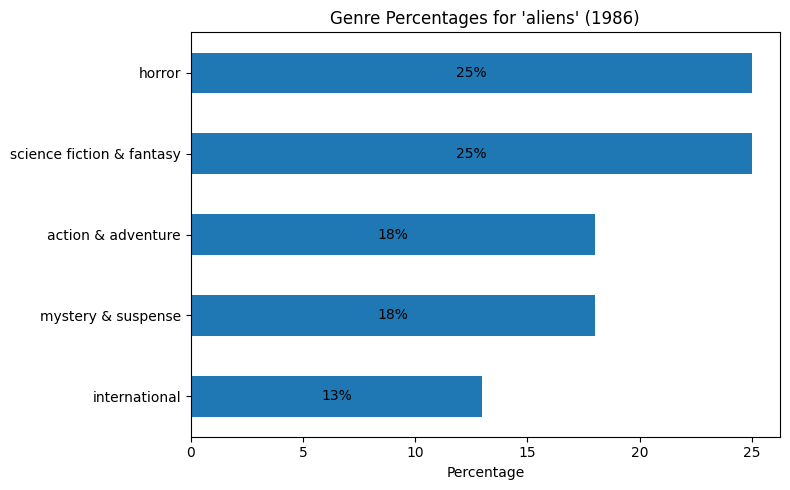


🎬 Genre Percentages (highest → lowest):
horror                       25.0
science fiction & fantasy    25.0
action & adventure           18.0
mystery & suspense           18.0
international                13.0
Name: 50, dtype: object


In [ ]:
from fuzzywuzzy import process
import matplotlib.pyplot as plt

# Build lowercase title → row mapping
title_map = {row["movie_title"].strip().lower(): row for idx, row in movie_genres_df.iterrows()}
all_titles = movie_genres_df["movie_title"].tolist()
lower_titles = [t.lower() for t in all_titles]
all_years = movie_genres_df["year"].tolist()

# Function to show genre plot sorted descending (highest at top)
def show_genre_plot(movie_title):
    row = title_map[movie_title.lower()]
    genre_cols = [c for c in movie_genres_df.columns if c not in ["movie_link","movie_title","year"]]
    genres = row[genre_cols].dropna()
    
    # Sort genres descending
    genres = genres.sort_values(ascending=False)
    
    plt.figure(figsize=(8,5))
    # Reverse order for barh to put highest at top
    ax = genres[::-1].plot(kind='barh')
    plt.title(f"Genre Percentages for '{row['movie_title']}' ({row['year']})")
    plt.xlabel("Percentage")
    
    # Add percentage labels inside the bars
    for bar in ax.patches:
        ax.text(
            bar.get_width() / 2,                      # x position
            bar.get_y() + bar.get_height() / 2,       # y position
            f"{int(bar.get_width())}%",                # label text
            ha='center',
            va='center'
        )
    plt.tight_layout()
    plt.show()
    
    print("\n🎬 Genre Percentages (highest → lowest):")
    print(genres)

# Single search cycle
user_text = input("🎬 Enter movie name: ").strip()
user_text_lower = user_text.lower()

# Exact match
if user_text_lower in title_map:
    print(f"🎯 Exact match found: {title_map[user_text_lower]['movie_title']} ({title_map[user_text_lower]['year']})\n")
    show_genre_plot(title_map[user_text_lower]['movie_title'])
else:
    # Fuzzy suggestions
    suggestions = process.extract(user_text_lower, lower_titles, limit=5)
    print("❌ Exact match not found.\n🔎 Did you mean one of these?\n")
    
    for i, (suggestion_text, score) in enumerate(suggestions, start=1):
        idx = lower_titles.index(suggestion_text)
        real_title = all_titles[idx]
        year = all_years[idx]
        print(f"{i}. {real_title} ({year})  ({score}%)")
    
    # Ask user to select suggestion by number
    selection = input("\nType the number of the movie you want to select (or 0 to cancel): ").strip()
    if selection.isdigit():
        selection = int(selection)
        if 1 <= selection <= len(suggestions):
            idx = lower_titles.index(suggestions[selection-1][0])
            selected_title = all_titles[idx]
            print(f"\n🎯 You selected: {selected_title}\n")
            show_genre_plot(selected_title)
        else:
            print("❌ Selection cancelled.")
    else:
        print("❌ Invalid input. Selection cancelled.")


✅ no_below=12, no_above=0.5, topics=8, dict_size=28188, coherence=0.3743
✅ no_below=12, no_above=0.5, topics=10, dict_size=28188, coherence=0.3998
✅ no_below=12, no_above=0.5, topics=12, dict_size=28188, coherence=0.4023
✅ no_below=12, no_above=0.5, topics=15, dict_size=28188, coherence=0.4051
✅ no_below=12, no_above=0.6, topics=8, dict_size=28200, coherence=0.3559
✅ no_below=12, no_above=0.6, topics=10, dict_size=28200, coherence=0.3569
✅ no_below=12, no_above=0.6, topics=12, dict_size=28200, coherence=0.3521
✅ no_below=12, no_above=0.6, topics=15, dict_size=28200, coherence=0.3536
✅ no_below=12, no_above=0.7, topics=8, dict_size=28206, coherence=0.3291
✅ no_below=12, no_above=0.7, topics=10, dict_size=28206, coherence=0.3296
✅ no_below=12, no_above=0.7, topics=12, dict_size=28206, coherence=0.3302
✅ no_below=12, no_above=0.7, topics=15, dict_size=28206, coherence=0.3269
✅ no_below=10, no_above=0.5, topics=8, dict_size=30515, coherence=0.3686
✅ no_below=10, no_above=0.5, topics=10, di

,no_below,no_above,num_topics,dictionary_size,coherence
0,12,0.5,15,28188,0.405054
1,12,0.5,12,28188,0.402275
2,12,0.5,10,28188,0.399755
3,7,0.5,10,35715,0.393330
4,5,0.5,12,41379,0.390135
5,7,0.5,15,35715,0.384358
6,7,0.5,12,35715,0.383651
7,10,0.6,12,30527,0.382175
8,7,0.5,8,35715,0.381974
9,10,0.5,12,30515,0.380997



🏆 Best dictionary + topic combination:
no_below=12.0, no_above=0.5, num_topics=15.0, dict_size=28188.0, coherence=0.4051


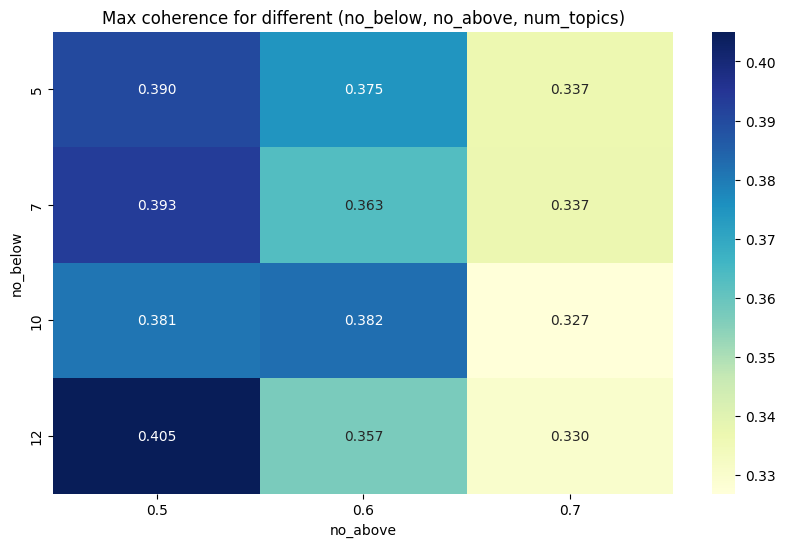

In [ ]:
# -------------------------------
# Full pipeline: Best dictionary + best topics
# -------------------------------

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# User parameters
# -------------------------------
texts = embedding_df["tokens"].tolist()
no_below_values = [12, 10, 7, 5]     # candidate no_below
no_above_values = [0.5, 0.6, 0.7]   # candidate no_above
topic_numbers = [8, 10, 12, 15]      # candidate topics for coherence
passes = 5                             # smaller passes for speed (coherence sweep)

results = []

# -------------------------------
# Run grid search
# -------------------------------
for nb, na in itertools.product(no_below_values, no_above_values):
    # 1️⃣ Build dictionary
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=nb, no_above=na)
    
    # 2️⃣ Build corpus
    corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # Skip if dictionary is too small
    if len(dictionary) < 50:
        continue
    
    # 3️⃣ Try different number of topics
    for num_topics in topic_numbers:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=passes,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        
        # 4️⃣ Compute coherence
        coherencemodel = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        
        # Store results
        results.append({
            "no_below": nb,
            "no_above": na,
            "num_topics": num_topics,
            "dictionary_size": len(dictionary),
            "coherence": coherence
        })
        
        print(f"✅ no_below={nb}, no_above={na}, topics={num_topics}, dict_size={len(dictionary)}, coherence={coherence:.4f}")

# -------------------------------
# Results DataFrame
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("coherence", ascending=False).reset_index(drop=True)
display(results_df.head(10))  # show top 10 combinations

# -------------------------------
# Best combination
# -------------------------------
best = results_df.iloc[0]
print("\n🏆 Best dictionary + topic combination:")
print(f"no_below={best['no_below']}, no_above={best['no_above']}, num_topics={best['num_topics']}, dict_size={best['dictionary_size']}, coherence={best['coherence']:.4f}")

# -------------------------------
# Plot coherence heatmap
# -------------------------------
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.pivot_table(index='no_below', columns='no_above', values='coherence', aggfunc='max'),
    annot=True, fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Max coherence for different (no_below, no_above, num_topics)")
plt.show()


✅ no_below=12, no_above=0.5, topics=15, dict_size=28188, coherence=0.4051
✅ no_below=12, no_above=0.5, topics=20, dict_size=28188, coherence=0.3917
✅ no_below=12, no_above=0.5, topics=25, dict_size=28188, coherence=0.3835
✅ no_below=12, no_above=0.5, topics=30, dict_size=28188, coherence=0.3785
✅ no_below=15, no_above=0.5, topics=15, dict_size=25540, coherence=0.3900
✅ no_below=15, no_above=0.5, topics=20, dict_size=25540, coherence=0.3776
✅ no_below=15, no_above=0.5, topics=25, dict_size=25540, coherence=0.3887
✅ no_below=15, no_above=0.5, topics=30, dict_size=25540, coherence=0.3733
✅ no_below=18, no_above=0.5, topics=15, dict_size=23580, coherence=0.3992
✅ no_below=18, no_above=0.5, topics=20, dict_size=23580, coherence=0.4015
✅ no_below=18, no_above=0.5, topics=25, dict_size=23580, coherence=0.3810
✅ no_below=18, no_above=0.5, topics=30, dict_size=23580, coherence=0.3811
✅ no_below=20, no_above=0.5, topics=15, dict_size=22441, coherence=0.3755
✅ no_below=20, no_above=0.5, topics=20

,no_below,no_above,num_topics,dictionary_size,coherence
0,12,0.5,15,28188,0.405054
1,18,0.5,20,23580,0.401524
2,18,0.5,15,23580,0.399229
3,12,0.5,20,28188,0.391664
4,15,0.5,15,25540,0.389990
5,20,0.5,20,22441,0.389511
6,15,0.5,25,25540,0.388679
7,12,0.5,25,28188,0.383474
8,18,0.5,30,23580,0.381089
9,18,0.5,25,23580,0.381031



🏆 Best dictionary + topic combination:
no_below=12.0, no_above=0.5, num_topics=15.0, dict_size=28188.0, coherence=0.4051


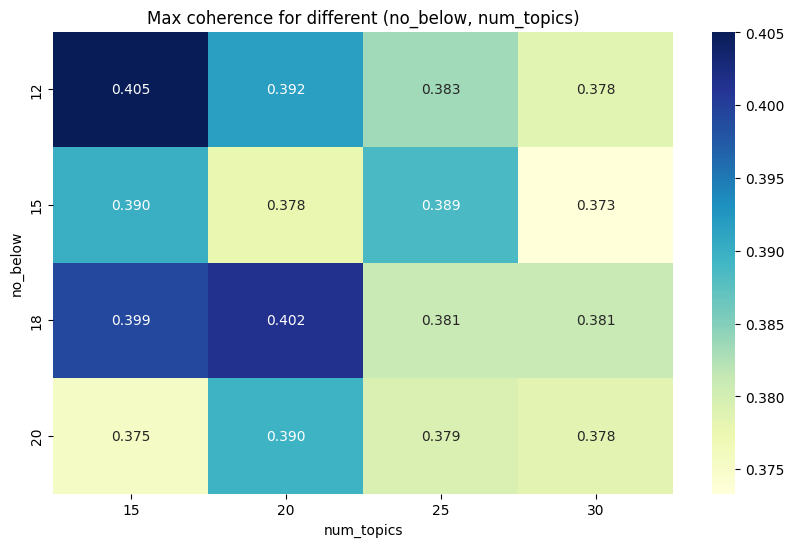

In [ ]:
# -------------------------------
# Full pipeline: Best dictionary + best topics
# -------------------------------

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# User parameters
# -------------------------------
texts = embedding_df["tokens"].tolist()
no_below_values = [12, 15, 18, 20]     # candidate no_below
no_above_values = [0.5]   # candidate no_above
topic_numbers = [15, 20, 25, 30]      # candidate topics for coherence
passes = 5                             # smaller passes for speed (coherence sweep)

results = []

# -------------------------------
# Run grid search
# -------------------------------
for nb, na in itertools.product(no_below_values, no_above_values):
    # 1️⃣ Build dictionary
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=nb, no_above=na)
    
    # 2️⃣ Build corpus
    corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # Skip if dictionary is too small
    if len(dictionary) < 50:
        continue
    
    # 3️⃣ Try different number of topics
    for num_topics in topic_numbers:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=passes,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        
        # 4️⃣ Compute coherence
        coherencemodel = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        
        # Store results
        results.append({
            "no_below": nb,
            "no_above": na,
            "num_topics": num_topics,
            "dictionary_size": len(dictionary),
            "coherence": coherence
        })
        
        print(f"✅ no_below={nb}, no_above={na}, topics={num_topics}, dict_size={len(dictionary)}, coherence={coherence:.4f}")

# -------------------------------
# Results DataFrame
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("coherence", ascending=False).reset_index(drop=True)
display(results_df.head(10))  # show top 10 combinations

# -------------------------------
# Best combination
# -------------------------------
best = results_df.iloc[0]
print("\n🏆 Best dictionary + topic combination:")
print(f"no_below={best['no_below']}, no_above={best['no_above']}, num_topics={best['num_topics']}, dict_size={best['dictionary_size']}, coherence={best['coherence']:.4f}")

# -------------------------------
# Plot coherence heatmap
# -------------------------------
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.pivot_table(index='no_below', columns='num_topics', values='coherence', aggfunc='max'),
    annot=True, fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Max coherence for different (no_below, num_topics)")
plt.show()


✅ no_below=15, no_above=0.5, topics=30, dict_size=25540, coherence=0.3733
✅ no_below=15, no_above=0.5, topics=35, dict_size=25540, coherence=0.3746
✅ no_below=15, no_above=0.5, topics=40, dict_size=25540, coherence=0.3905
✅ no_below=15, no_above=0.5, topics=45, dict_size=25540, coherence=0.3833


,no_below,no_above,num_topics,dictionary_size,coherence
0,15,0.5,40,25540,0.390514
1,15,0.5,45,25540,0.383303
2,15,0.5,35,25540,0.374611
3,15,0.5,30,25540,0.373325



🏆 Best dictionary + topic combination:
no_below=15.0, no_above=0.5, num_topics=40.0, dict_size=25540.0, coherence=0.3905


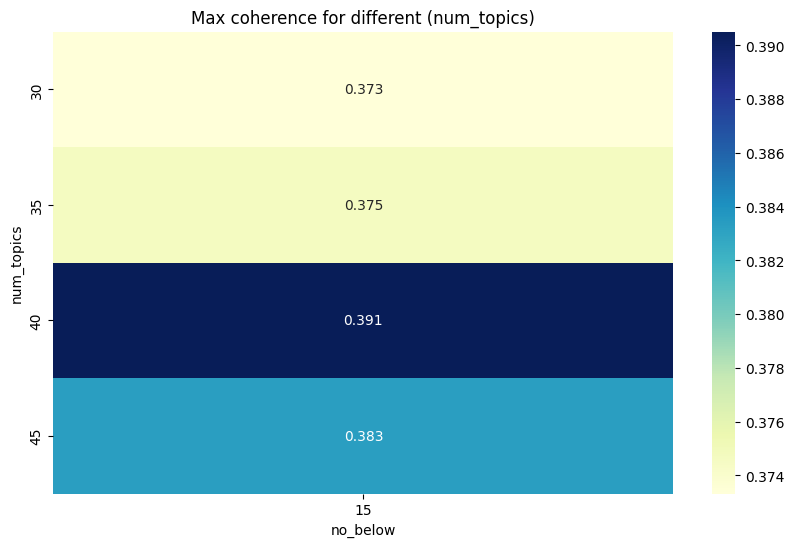

In [ ]:
# -------------------------------
# Full pipeline: Best dictionary + best topics
# -------------------------------

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# User parameters
# -------------------------------
texts = embedding_df["tokens"].tolist()
no_below_values = [15]     # candidate no_below
no_above_values = [0.5]   # candidate no_above
topic_numbers = [30,35,40,45]      # candidate topics for coherence
passes = 5                             # smaller passes for speed (coherence sweep)

results = []

# -------------------------------
# Run grid search
# -------------------------------
for nb, na in itertools.product(no_below_values, no_above_values):
    # 1️⃣ Build dictionary
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=nb, no_above=na)
    
    # 2️⃣ Build corpus
    corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # Skip if dictionary is too small
    if len(dictionary) < 50:
        continue
    
    # 3️⃣ Try different number of topics
    for num_topics in topic_numbers:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=passes,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        
        # 4️⃣ Compute coherence
        coherencemodel = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        
        # Store results
        results.append({
            "no_below": nb,
            "no_above": na,
            "num_topics": num_topics,
            "dictionary_size": len(dictionary),
            "coherence": coherence
        })
        
        print(f"✅ no_below={nb}, no_above={na}, topics={num_topics}, dict_size={len(dictionary)}, coherence={coherence:.4f}")

# -------------------------------
# Results DataFrame
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("coherence", ascending=False).reset_index(drop=True)
display(results_df.head(10))  # show top 10 combinations

# -------------------------------
# Best combination
# -------------------------------
best = results_df.iloc[0]
print("\n🏆 Best dictionary + topic combination:")
print(f"no_below={best['no_below']}, no_above={best['no_above']}, num_topics={best['num_topics']}, dict_size={best['dictionary_size']}, coherence={best['coherence']:.4f}")

# -------------------------------
# Plot coherence heatmap
# -------------------------------
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.pivot_table(index='num_topics', columns='no_below', values='coherence', aggfunc='max'),
    annot=True, fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Max coherence for different (num_topics)")
plt.show()
